# <center><font color='#333333'>Multiple Cryptocurrencies Pricing Prediction using LSTM</font></center>




--------------------------------------------------------------------------------------

# Step 1 - Data Import

## 1.1 pricing dataset

In [32]:
import pandas as pd
cryptocurrency_df = pd.read_csv('cryptocurrency_df.csv')
cryptocurrency_df['Datetime'] = pd.to_datetime(cryptocurrency_df['Datetime'])
cryptocurrency_raw_df = cryptocurrency_df.copy()
print('Shape:', cryptocurrency_df.shape)
cryptocurrency_df.head()
import warnings
warnings.filterwarnings('ignore')

Shape: (44640, 20)


## 1.2 the coindesk 20

In [33]:
coindesk20_list = list(cryptocurrency_df.columns)[1:]
print(coindesk20_list)

['BTC', 'ETH', 'XRP', 'ADA', 'USDT', 'DOGE', 'XLM', 'DOT', 'UNI', 'LINK', 'USDC', 'BCH', 'LTC', 'GRT', 'ETC', 'FIL', 'AAVE', 'ALGO', 'EOS']


# Step 2 - Data Visualization

## 2.1 individual cryptocurrency pricing

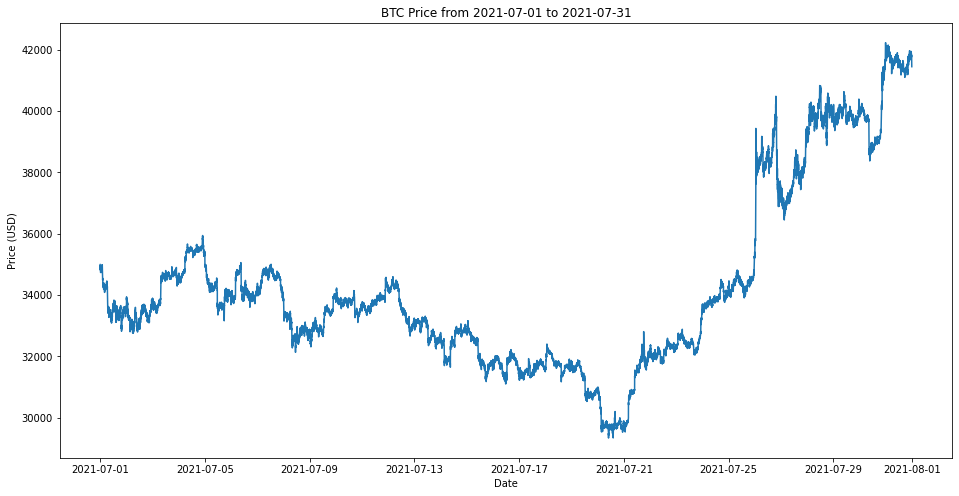

In [34]:
import matplotlib.pyplot as plt
coin = coindesk20_list[0]
plt.figure(figsize=(16,8))
plt.plot(cryptocurrency_df['Datetime'], cryptocurrency_df[coin])
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.title(coin + ' Price from ' + str(min(cryptocurrency_df['Datetime']))[:10] + ' to ' + str(max(cryptocurrency_df['Datetime']))[:10])
plt.show()

## 2.2 multiple cryptocurrencies pricing

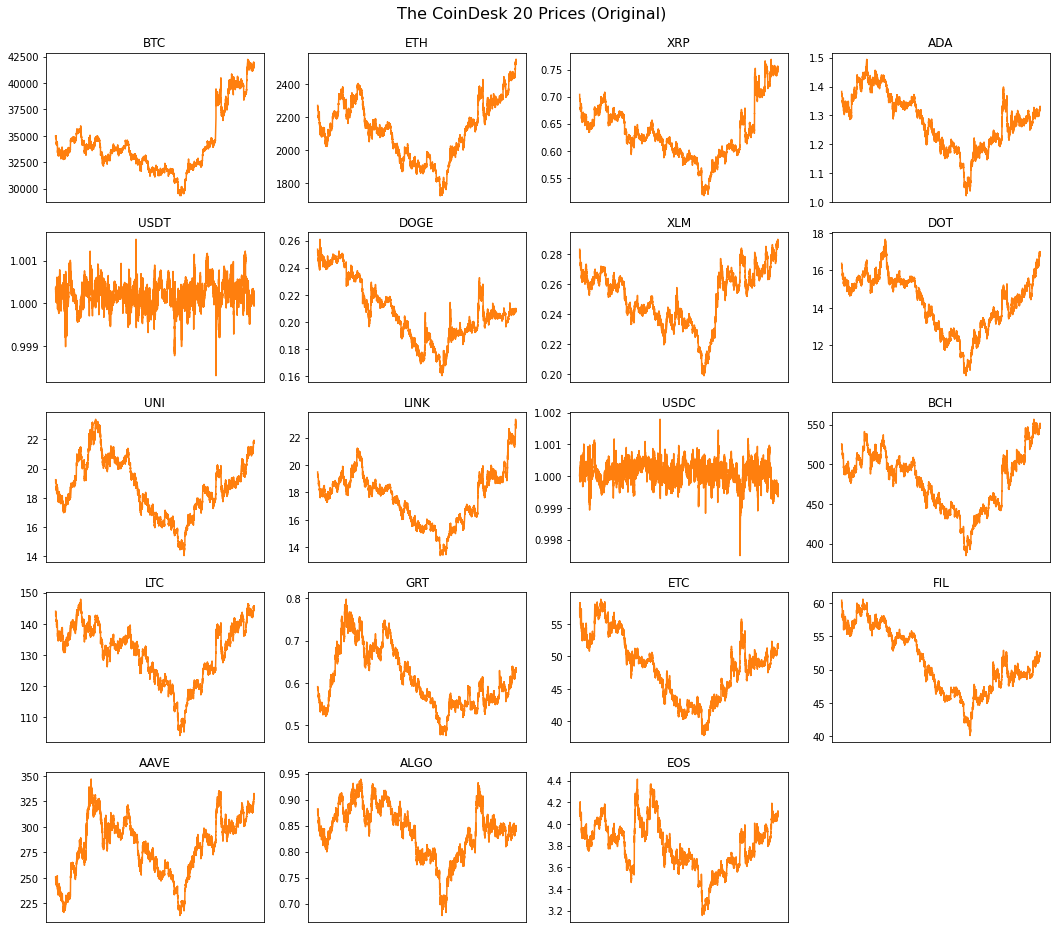

In [35]:
fig = plt.figure(figsize=(18,16))
fig.suptitle('The CoinDesk 20 Prices (Original)', fontsize=16, y = 0.92)
for i in range(len(coindesk20_list)):
    coin = coindesk20_list[i]
    plt.subplot(5, 4, i+1)
    plt.plot(cryptocurrency_df['Datetime'], cryptocurrency_df[coin], color = 'C1')
    plt.title(coin)
    plt.xticks([])
plt.show()

# Step 3 - Data Standardization

## 3.1 define parameters

In [36]:
testing_window = 1440      # 1 day
x_window = 180             # 3 hours
time_shift = 1             # 1 minute

## 3.2 standard scaler

In [37]:
from sklearn.preprocessing import StandardScaler
train_idx = int((len(cryptocurrency_df) - testing_window - x_window)*0.8) + x_window
sc = StandardScaler().fit(cryptocurrency_df.iloc[:train_idx, 1:])
cryptocurrency_df.iloc[:, 1:] = sc.transform(cryptocurrency_df.iloc[:, 1:])
print('Mean:', sc.mean_)
print('Variance:', sc.var_)

Mean: [3.29161396e+04 2.06774849e+03 6.18963434e-01 1.28166305e+00
 1.00020529e+00 2.08412132e-01 2.45644048e-01 1.41454234e+01
 1.85861717e+01 1.71791933e+01 1.00016331e+00 4.71804909e+02
 1.28918904e+02 6.20265031e-01 4.79304109e+01 5.15496429e+01
 2.73745176e+02 8.38884462e-01 3.78059469e+00]
Variance: [1.73689611e+06 2.44431862e+04 1.62091153e-03 1.12081651e-02
 7.07711688e-08 6.27498422e-04 2.89141489e-04 2.61863185e+00
 4.50111305e+00 2.92576054e+00 7.38311605e-08 1.23024373e+03
 9.01618119e+01 5.89410821e-03 2.97229452e+01 2.74135658e+01
 8.08832058e+02 3.08546720e-03 5.89420619e-02]


## 3.2 visualize the distribution

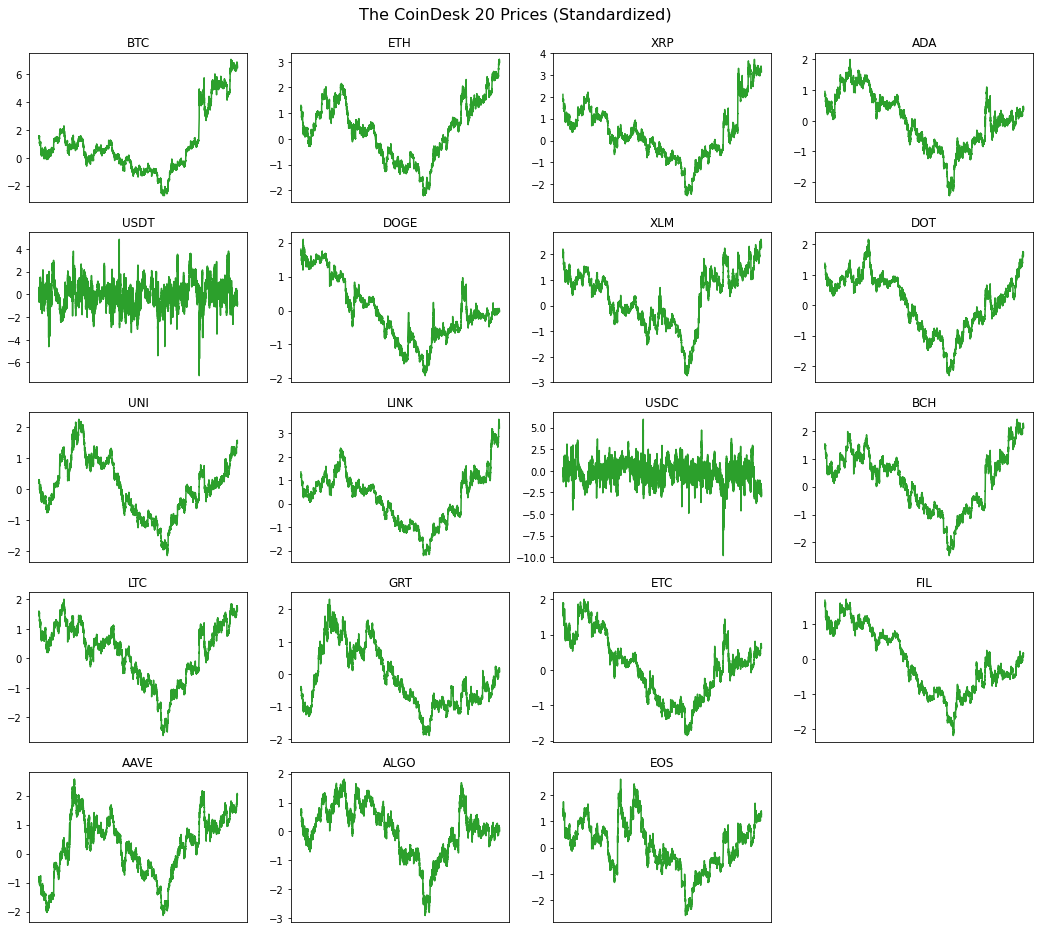

In [38]:
fig = plt.figure(figsize=(18,16))
fig.suptitle('The CoinDesk 20 Prices (Standardized)', fontsize=16, y = 0.92)
for i in range(len(coindesk20_list)):
    coin = coindesk20_list[i]
    plt.subplot(5, 4, i+1)
    plt.plot(cryptocurrency_df['Datetime'], cryptocurrency_df[coin], color = 'C2')    
    plt.title(coin)
    plt.xticks([])
plt.show()

# Step 4 - Data Splitting

## 4.1 drop the datetime

In [39]:
datetime_list = cryptocurrency_df['Datetime']
cryptocurrency_df = cryptocurrency_df.iloc[:, 1:]
print('Shape:', cryptocurrency_df.shape)
cryptocurrency_df.head()

Shape: (44640, 19)


,BTC,ETH,XRP,ADA,USDT,DOGE,XLM,DOT,UNI,LINK,USDC,BCH,LTC,GRT,ETC,FIL,AAVE,ALGO,EOS
0,1.576624,1.300286,2.112766,0.955603,0.463370,1.806964,2.201754,1.378858,0.310439,1.353556,-0.522990,1.540041,1.593796,-0.383212,1.752679,1.685779,-0.808783,0.772162,1.470004
1,1.574555,1.281591,2.014658,0.925626,0.488078,1.793575,2.081582,1.342443,0.252203,1.304560,-0.475803,1.497597,1.573432,-0.407408,1.669535,1.629360,-0.844917,0.757306,1.388287
2,1.545102,1.272161,2.030311,0.907187,0.251806,1.777742,2.080736,1.315510,0.240030,1.286322,-0.377595,1.457832,1.547884,-0.423329,1.641423,1.598080,-0.849273,0.737984,1.360529
3,1.552082,1.255166,2.008207,0.903654,0.487998,1.776490,2.062322,1.321347,0.254731,1.281516,-0.196175,1.465885,1.547168,-0.420902,1.653700,1.602254,-0.838035,0.744148,1.364094
4,1.563416,1.269562,2.043575,0.922306,0.273348,1.782769,2.061888,1.330153,0.265009,1.288916,-0.661438,1.481932,1.543899,-0.410389,1.626939,1.605325,-0.826685,0.754023,1.375129


## 4.2 transform the dataset

In [40]:
%%time
from tqdm import tqdm
import numpy as np

X = np.zeros((len(cryptocurrency_df)-x_window-time_shift+1, len(cryptocurrency_df.columns), x_window))
Y = np.zeros((len(cryptocurrency_df)-x_window-time_shift+1, len(cryptocurrency_df.columns), 1))

for i in tqdm(range(X.shape[0])):
    X[i] = np.array(cryptocurrency_df.iloc[i:i+x_window]).T
    Y[i] = np.array(cryptocurrency_df.loc[i+x_window+time_shift-1])[:,np.newaxis]

print('X Shape:', X.shape)
print('Y Shape:', Y.shape)

100%|██████████████████████████████████| 44460/44460 [00:03<00:00, 12930.22it/s]

X Shape: (44460, 19, 180)
Y Shape: (44460, 19, 1)
CPU times: user 3.08 s, sys: 366 ms, total: 3.44 s
Wall time: 3.44 s


## 3.3 split train, validation and test sets

In [41]:
X_train = X[:-testing_window]
Y_train = Y[:-testing_window]
X_test = X[-testing_window:]
Y_test = Y[-testing_window:]
val_idx = int(X_train.shape[0]*0.8)
X_val = X_train[val_idx:]
Y_val = Y_train[val_idx:]
X_train = X_train[:val_idx]
Y_train = Y_train[:val_idx]
print('X_train Shape:', X_train.shape)
print('Y_train Shape:', Y_train.shape)
print('X_val Shape:', X_val.shape)
print('Y_val Shape:', Y_val.shape)
print('X_test Shape:', X_test.shape)
print('Y_test Shape:', Y_test.shape)

X_train Shape: (34416, 19, 180)
Y_train Shape: (34416, 19, 1)
X_val Shape: (8604, 19, 180)
Y_val Shape: (8604, 19, 1)
X_test Shape: (1440, 19, 180)
Y_test Shape: (1440, 19, 1)


# Step 5 - LSTM Model

## 5.1 model architecture

In [42]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.LSTM(64, input_shape=X.shape[1:], activation="relu", return_sequences=True),
    layers.Dense(1),])

opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.01, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=opt)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 19, 64)            62720     
                                                                 
 dense_1 (Dense)             (None, 19, 1)             65        
                                                                 
Total params: 62,785
Trainable params: 62,785
Non-trainable params: 0
_________________________________________________________________


## 5.2 model training

In [27]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
history = model.fit(X_train, Y_train, epochs=3, validation_data=(X_val, Y_val), shuffle=True, batch_size=8, verbose=1, callbacks=[callback])

Epoch 1/3
  19/4302 [..............................] - ETA: 24s - loss: 0.0100

2022-10-14 13:39:13.993702: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 470810880 exceeds 10% of free system memory.


4302/4302 [==============================] - 29s 7ms/step - loss: 0.0116 - val_loss: 0.0193
Epoch 2/3
4302/4302 [==============================] - 29s 7ms/step - loss: 0.0105 - val_loss: 0.0159
Epoch 3/3
4302/4302 [==============================] - 29s 7ms/step - loss: 0.0098 - val_loss: 0.0163


## 5.3 model history

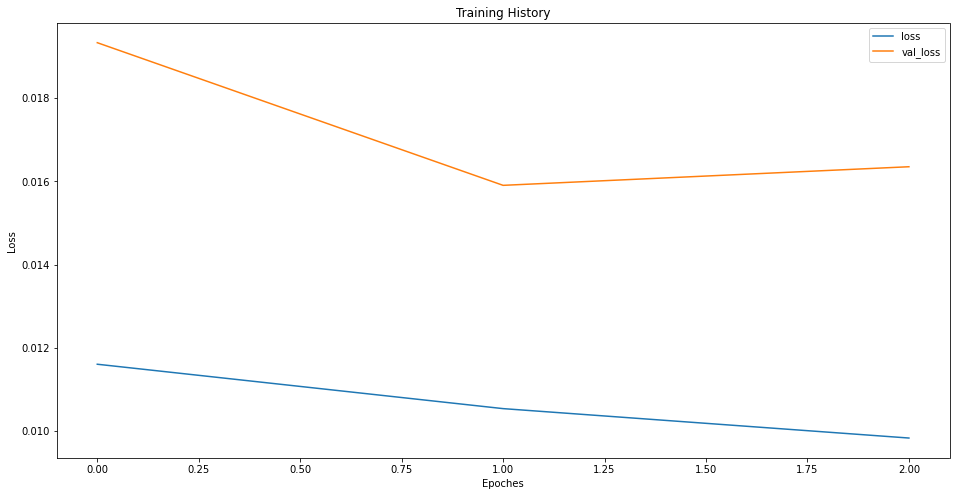

In [28]:
plt.figure(figsize = (16,8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.title('Training History')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.show()

# Step 6 - Model Inference

## 6.1 test set prediction

In [29]:
Y_pred = model.predict(X_test)[:, :, 0]
pred_df = pd.DataFrame(sc.inverse_transform(Y_pred), columns=coindesk20_list, index=list(datetime_list[-len(Y_pred):]))
pred_df = pred_df.rename_axis('Datetime').reset_index()
pred_df.head()

45/45 [==============================] - 0s 4ms/step


,Datetime,BTC,ETH,XRP,ADA,USDT,DOGE,XLM,DOT,UNI,LINK,USDC,BCH,LTC,GRT,ETC,FIL,AAVE,ALGO,EOS
0,2021-07-31 00:00:00,42571.960938,2460.780518,0.757217,1.283251,0.999971,0.207369,0.282907,15.906979,21.106415,22.582047,0.999649,549.939941,145.935394,0.598436,51.267021,51.483322,320.760223,0.854011,4.070108
1,2021-07-31 00:01:00,42617.109375,2462.086182,0.758630,1.285618,0.999954,0.207268,0.283303,15.933302,21.103189,22.587286,0.999643,550.236389,145.957809,0.599168,51.273781,51.547058,320.380524,0.854152,4.072080
2,2021-07-31 00:02:00,42585.785156,2457.162598,0.757740,1.285157,0.999951,0.208458,0.283700,15.950746,21.116768,22.555958,0.999670,550.053589,145.717239,0.598827,51.222221,51.560295,320.101868,0.853072,4.073216
3,2021-07-31 00:03:00,42544.011719,2452.122803,0.756514,1.284147,0.999979,0.207957,0.283121,15.866866,21.050901,22.472164,0.999693,549.182251,145.575577,0.596810,50.915367,51.443268,319.455597,0.851680,4.065991
4,2021-07-31 00:04:00,42566.765625,2451.320068,0.756230,1.284798,0.999985,0.208451,0.283184,15.825882,21.002176,22.444782,0.999624,551.164612,145.903763,0.593447,50.882118,51.398479,319.752686,0.850889,4.061336


## 6.2 visualize individual cryptocurrency pricing

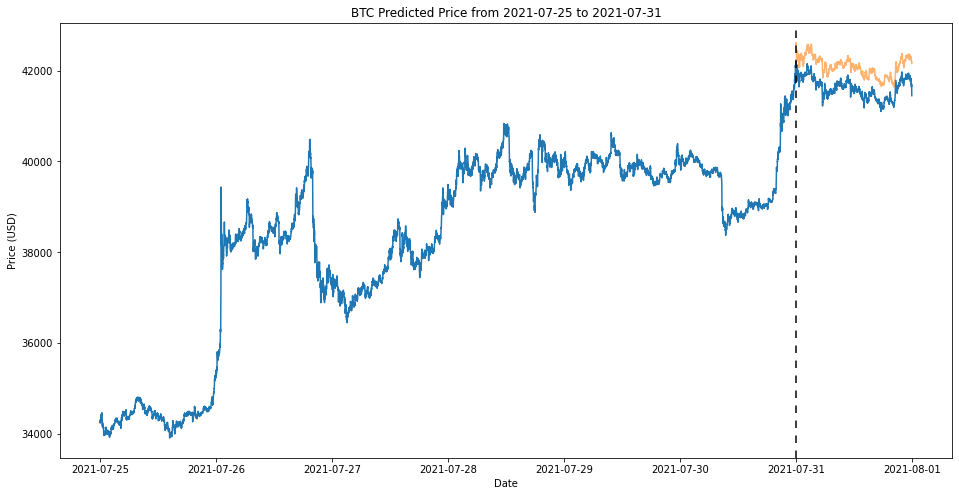

In [30]:
coin = coindesk20_list[0]
plt.figure(figsize=(16,8))
temp_df = cryptocurrency_raw_df.iloc[-1440*7:]
plt.plot(temp_df['Datetime'], temp_df[coin])
plt.plot(pred_df['Datetime'], pred_df[coin], alpha = 0.6)
plt.axvline(x=min(pred_df['Datetime']), color='k', linestyle=(0, (5, 5)))
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.title(coin + ' Predicted Price from ' + str(min(temp_df['Datetime']))[:10] + ' to ' + str(max(temp_df['Datetime']))[:10])
plt.show()

## 6.3 visualize multiple cryptocurrencies pricing

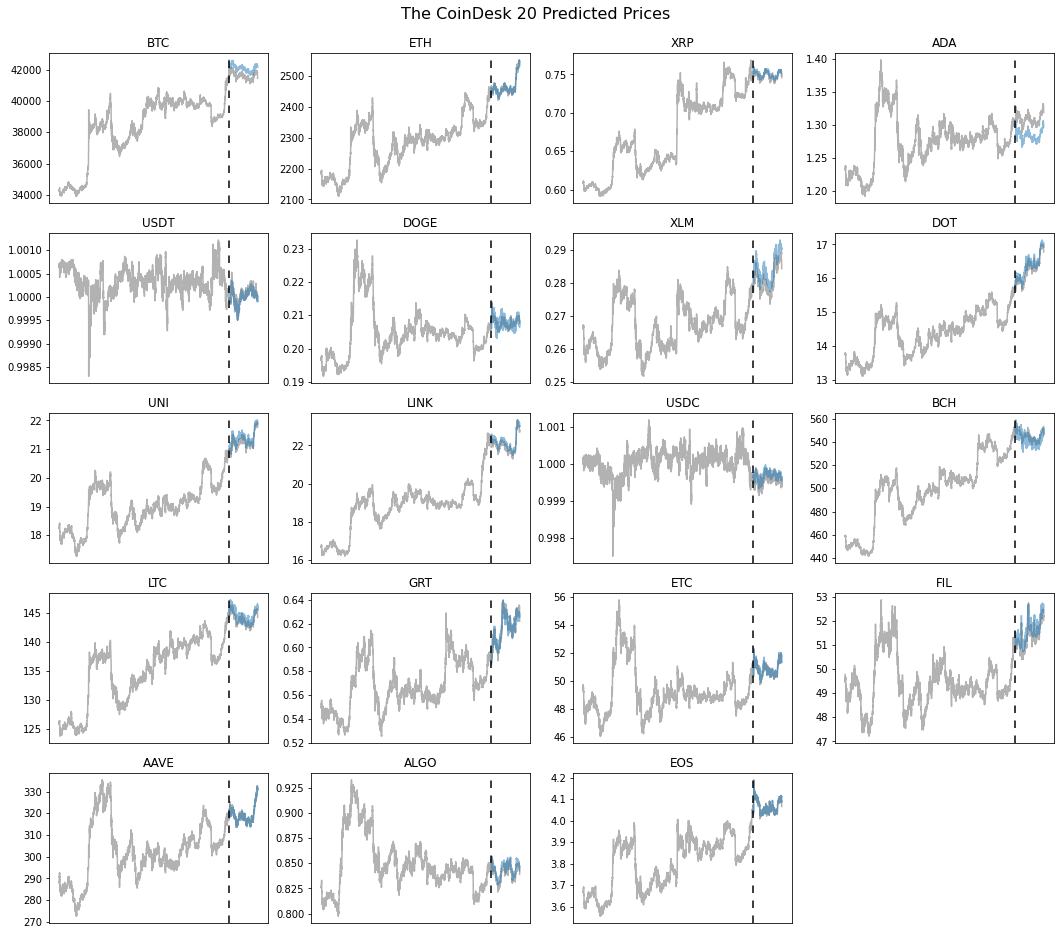

In [31]:
temp_df = cryptocurrency_raw_df.iloc[-1440*7:]
fig = plt.figure(figsize=(18,16))
fig.suptitle('The CoinDesk 20 Predicted Prices', fontsize=16, y = 0.92)
for i in range(len(coindesk20_list)):
    coin = coindesk20_list[i]
    plt.subplot(5, 4, i+1)    
    plt.plot(temp_df['Datetime'], temp_df[coin], color = 'k', alpha = 0.3)
    plt.plot(pred_df['Datetime'], pred_df[coin], alpha = 0.5)
    plt.axvline(x=min(pred_df['Datetime']), color='k', linestyle=(0, (5, 5)))
    plt.title(coin)
    plt.xticks([])
plt.show()